In [2]:
import pandas as pd
import time
import seaborn as sns
import numpy as np
import os
from scattering_data import DataLoader
from vbi_elbo import MCElboMF, MCElboFG, correlation_from_covariance
import torch
import copy
import pickle as pkl
import matplotlib.pyplot as plt

import corner

# Plotting utilities

In [3]:
def specs(x, **kwargs):
    ax = sns.histplot(x=x)
    ax.set_ylim(ax.get_ylim()[0], ax.get_ylim()[1] + 10)
    ax.text(x.mean() - 3 * x.std(), kwargs["top"], f'{np.round(x.mean(),3)}' + r'$\pm$' + f'{np.round(x.std(),4)}')

# Loading Data

In [4]:
names = ["A0", "r0", "C1+^2", "P1+", "C1-^2", "P1-"]
#data_train = DataLoader(4.342, "som")
data_train = DataLoader(2.624, "som")
print(data_train.data.shape)

(293, 4)


# Mean field fit and analysis

In [257]:
seed = 14
torch.manual_seed(seed)

### Data 
x_train = torch.tensor(data_train.theta_cs)
y_train = torch.tensor(data_train.cs_data)

### torch.nn.Module class instance
nMC = 5
param_dim = 6
x_dim = 1
model = MCElboMF(nMC = nMC, x_dim = x_dim,
                 param_dim = param_dim,
                 f_dim = data_train.f_bounds.shape[0],
                 theta_cs = data_train.theta_cs,
                 err_cs = data_train.err_cs,
                 Elab_cs = data_train.Elab_cs, f_sigmas = data_train.f_sigmas, cov_theory = True, recompute_values = True,
                 which_data = "som", barnard_Elab = None, l_som = data_train.l_som)

learning_rate = 5e-2
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
n_steps = 12000
# Saving intermediate results
loss_array = np.zeros(n_steps)
time_array = np.zeros(n_steps)
param_dictionary = {}
for name, param in model.named_parameters():
    param_dictionary[name] = []
    
startTime = time.time()
for t in range(n_steps):
    # Compute ELBO
    loss = - model.compute_elbo_loop(x_train, y_train)
    # Zero gradinets
    optimizer.zero_grad()
    # Compute gradients
    loss.backward()
    optimizer.step()
    
    # Utiliti computation
    loss_array[t] = loss.item()
    time_array[t] = time.time() - startTime 
    
    if t % 10 == 9: 
        for name, param in model.named_parameters():
            param_dictionary[name] = param_dictionary[name] + [param.detach().clone().numpy()]
    
    if t % 2000 == 1999:
        print(f"Loss: {loss.item()}, Step [{t}/{n_steps}]")
        print(model.ModelString())
        # Time estimmate
        print(f"Minutes remaining {(time.time() - startTime) * (n_steps - t) / (t * 60)}")

endTime = time.time()
print(endTime - startTime)

Loss: -372.5877685546875, Step [1999/12000]
theta mean: Parameter containing:
tensor([[ 0.0172,  0.8216, 15.4837,  1.7286, 13.6138,  1.2491,  0.9825,  0.9327,
          1.0540,  1.0167,  1.0323,  1.0257,  1.0357]], dtype=torch.float64,
       requires_grad=True) 
 theta std tensor([[6.7852e-04, 9.8416e-03, 5.8173e-01, 7.7165e-02, 9.5881e-01, 1.8987e-01,
         5.6756e-03, 3.8034e-03, 2.9443e-03, 2.7524e-03, 2.1782e-03, 2.5553e-03,
         2.2373e-03]], dtype=torch.float64, grad_fn=<SoftplusBackward0>)
Minutes remaining 4.20006851632535
Loss: -483.5354919433594, Step [3999/12000]
theta mean: Parameter containing:
tensor([[1.3902e-02, 8.5879e-01, 1.5463e+01, 1.9395e+00, 1.3196e+01, 7.3589e-01,
         9.6332e-01, 9.2285e-01, 1.0641e+00, 1.0043e+00, 1.0235e+00, 1.0113e+00,
         1.0162e+00]], dtype=torch.float64, requires_grad=True) 
 theta std tensor([[3.7285e-04, 6.0540e-03, 3.0103e-01, 1.5888e-02, 1.1953e+00, 9.1202e-02,
         5.6374e-03, 3.4126e-03, 2.7573e-03, 2.6033e-03, 2

## Saving results

In [258]:
folder = "Outputs"
run_id = "som_mf_" + str(seed) + "_"

if not os.path.exists(folder):
    os.makedirs(folder)

dictionary_outputs = copy.deepcopy(param_dictionary)
dictionary_outputs["ELBO"] = -loss_array
dictionary_outputs["time"] = time_array
with open(folder + "/" + run_id + "outputs_" + "vars" + '.pickle', 'wb') as handle:
    pkl.dump(dictionary_outputs, handle, protocol=pkl.HIGHEST_PROTOCOL)

## Loading results

In [20]:
folder = "Outputs"
run_id = "som_mf_7_"

with open(folder + "/" + run_id + "outputs_" + "vars" + '.pickle', 'rb') as handle:
    dictionary_outputs = pkl.load(handle)
time_array = dictionary_outputs["time"]
loss_array = - dictionary_outputs["ELBO"]
param_dictionary = copy.deepcopy(dictionary_outputs)

## Fit plots

398.80216139157613


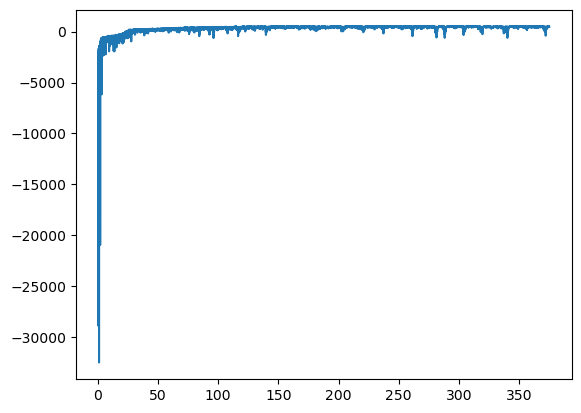

In [21]:
# ELBO
plt.plot(time_array[10:], -loss_array[10:])
print(np.mean(-loss_array[-150:]))
plt.show()

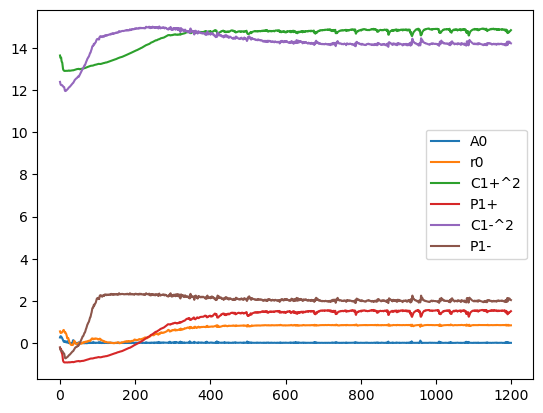

In [22]:
# Means
plt.plot(np.array(param_dictionary["q_theta_m"])[:,0,:6])
plt.legend(names)
plt.show()

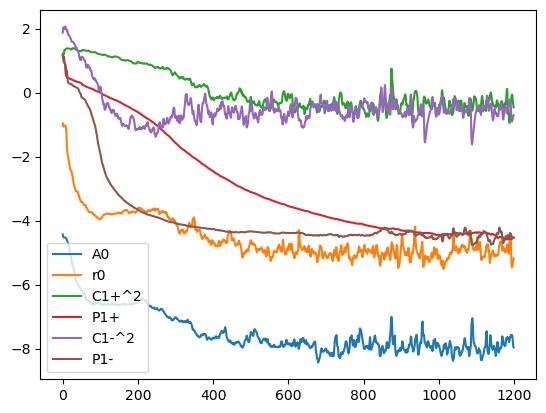

In [23]:
# SD
plt.plot(np.array(param_dictionary["q_theta_s"])[:,0,:6])
plt.legend(names)
plt.show()

### Posteriors

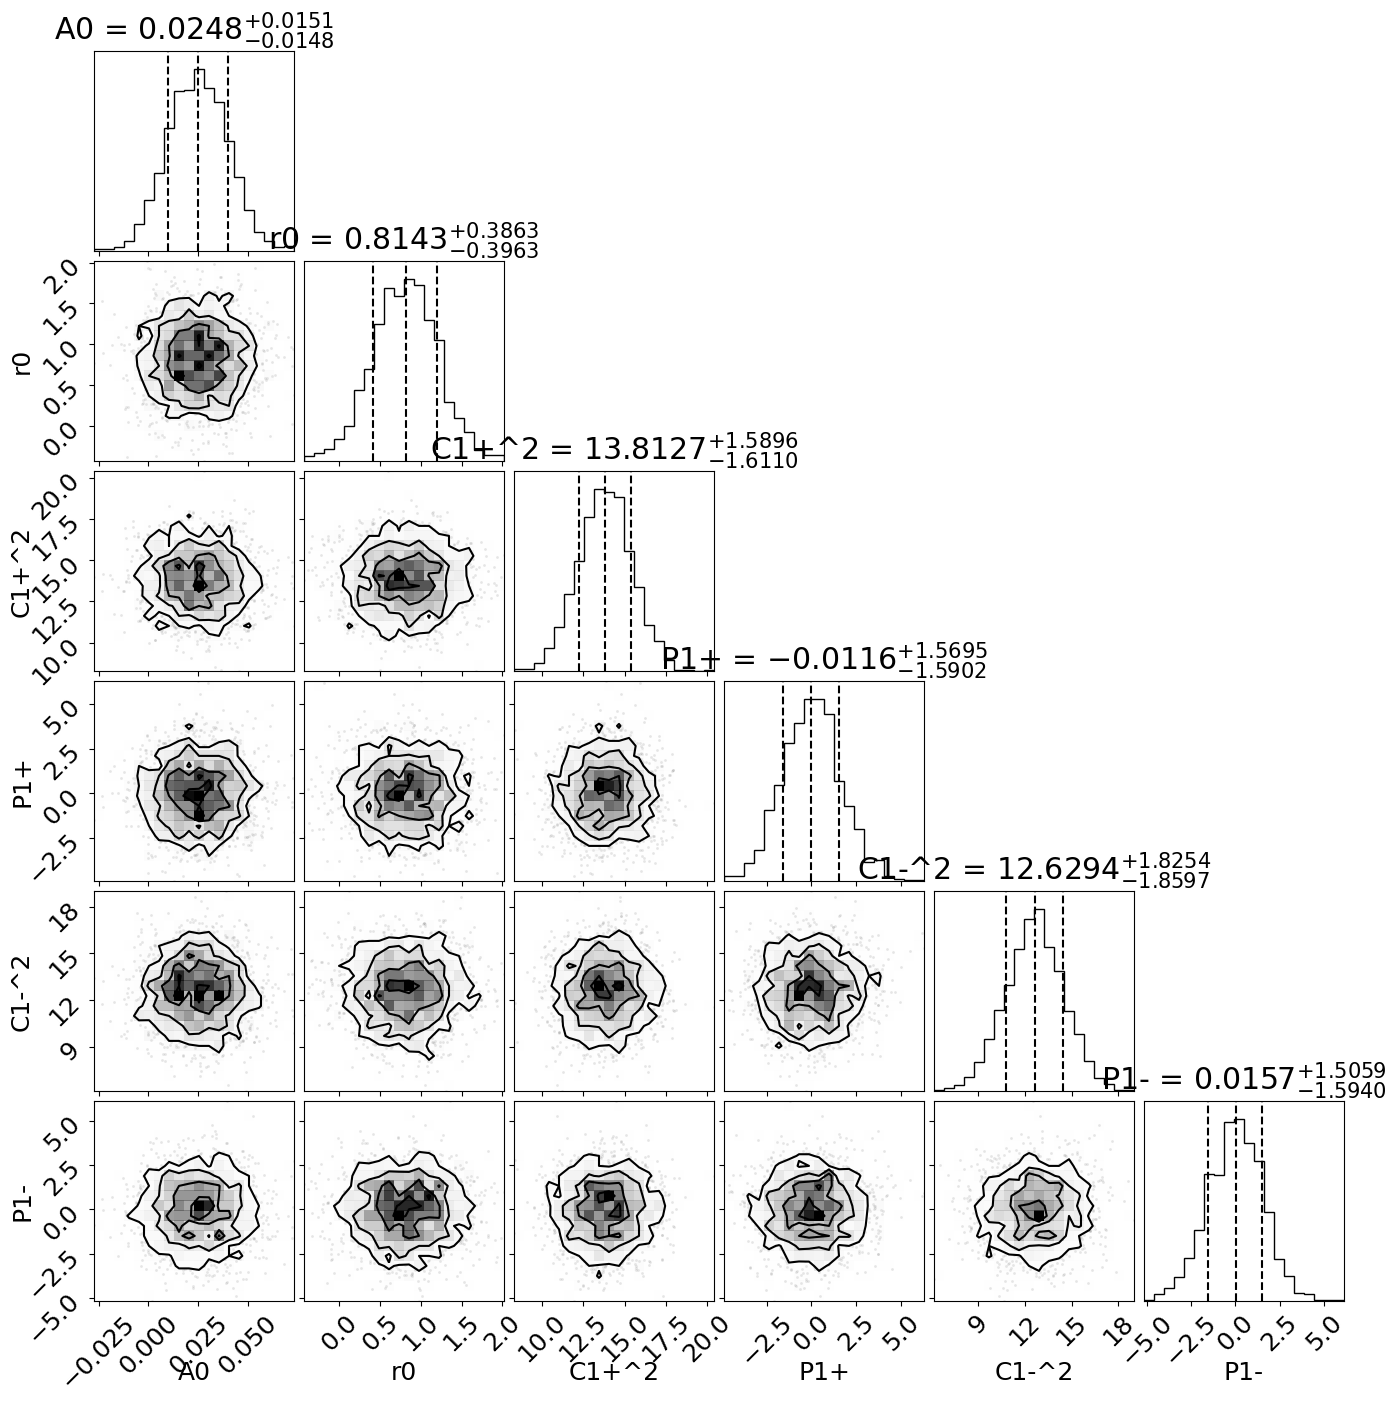

In [26]:
# VI Psoteriors
model.nMC = 2000
z = model.generate_sample(n_var = model.param_dim + model.f_dim)
theta = model.sample_reparam_normal(z, model.q_theta_m, model.q_theta_s)

alpha = 1
bins = 100
plt.rcParams.update({'font.size': 18})
samples = pd.DataFrame(theta.detach().numpy().reshape(model.nMC, model.param_dim +model.f_dim)[:,:6], columns = names)
#g = sns.PairGrid(samples)
#g.map_diag(plt.hist, bins = bins, alpha = alpha, color = "blue", density= True)
#g.map_lower(sns.kdeplot, shade= True, thresh=0.05, color = "blue")
#plt.show()
corner.corner(samples.values, labels = samples.columns, quantiles = [0.16, 0.5, 0.84], title_fmt = '.4f', show_titles = True)
plt.show()

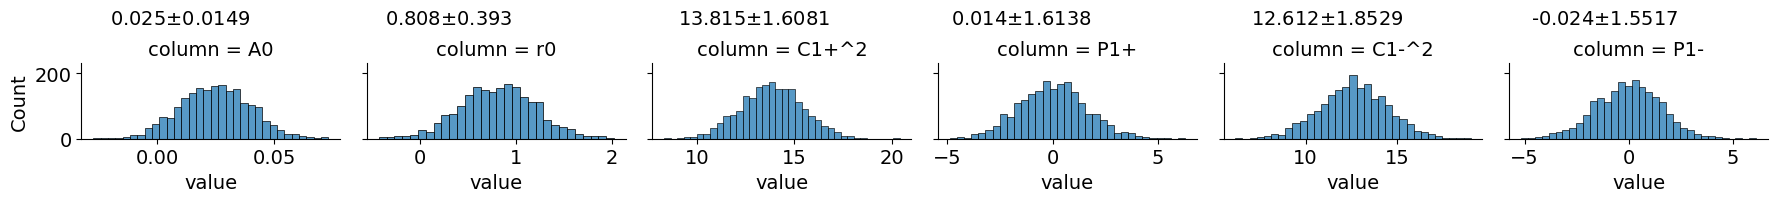

In [27]:
samples_melted = samples.melt(var_name='column')
plt.rcParams.update({'font.size': 14})
g = sns.FacetGrid(samples_melted, col='column', sharex=False)
g.map(specs, 'value', top  = 350)
plt.show()

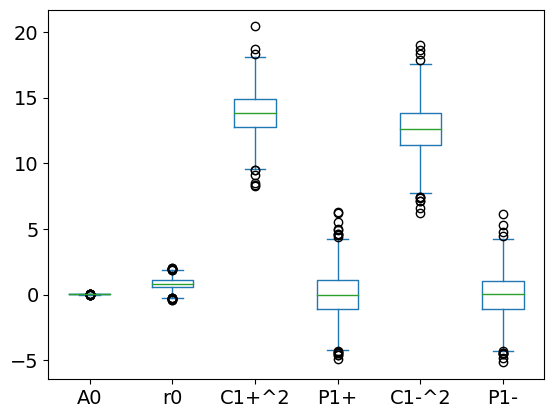

In [28]:
samples.plot(kind = "box")
plt.show()

### Posteriors - Multiple runs

In [34]:
folder = "Outputs"

ELBO = {}
posteriors = {}

for seed in range(10):
    run_id = "som_mf_" + str(seed) + "_"
    with open(folder + "/" + run_id + "outputs_" + "vars" + '.pickle', 'rb') as handle:
        dictionary_outputs = pkl.load(handle)
    time_array = dictionary_outputs["time"]
    loss_array = - dictionary_outputs["ELBO"]
    ELBO[run_id] = loss_array
    param_dictionary = copy.deepcopy(dictionary_outputs)
    posteriors[run_id] = param_dictionary

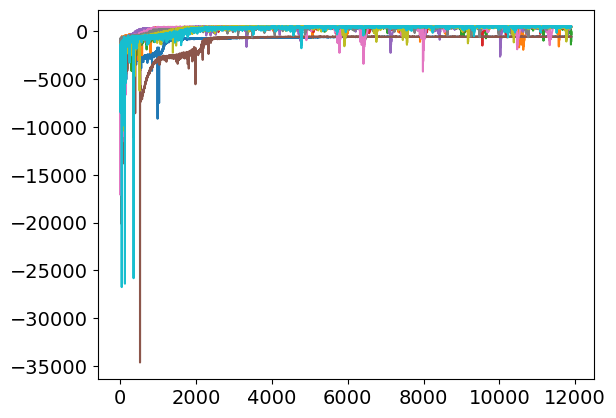

In [35]:
weights = {}
for index, (key, value) in enumerate(ELBO.items()):
    plt.plot(- value[100:])
    weights[key] = np.mean(- value[-3000:])
plt.show()
weights = pd.DataFrame(weights.items())
weights.columns = ["id", "ELBO"]
weights["p"] = np.exp(weights["ELBO"]) / np.sum(np.exp(weights["ELBO"]))
weights["pCum"] = np.cumsum(weights["p"])

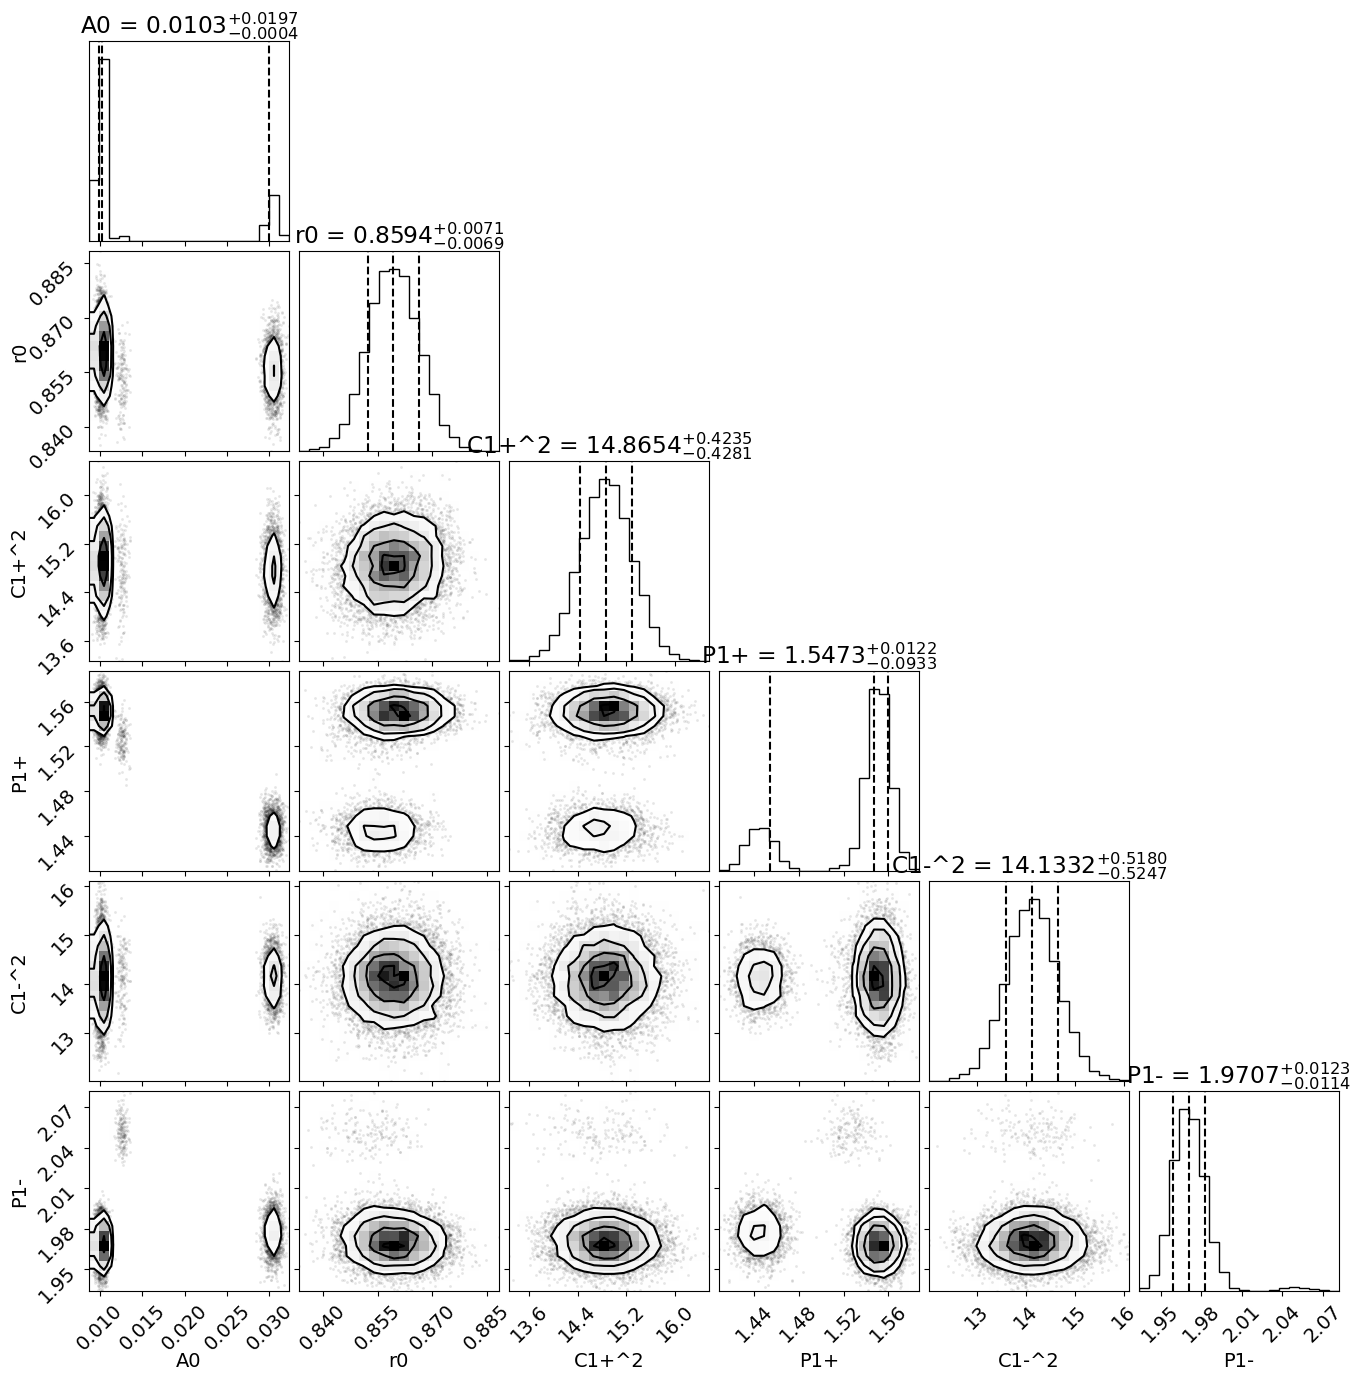

In [290]:
# VI Psoteriors
samples = 10000
theta = np.zeros((samples, model.param_dim + model.f_dim))
indices_array = np.zeros(samples)
for i in range(samples):
    u = np.random.uniform()
    states = (weights["pCum"] - u) > 0
    index_model = str(np.where(states)[0][0])
    indices_array[i] = np.where(states)[0][0]
    #index_model = str(9)
    #print(index)
    model.nMC = 1
    z = model.generate_sample(n_var = model.param_dim + model.f_dim)
    theta[i,:]  = model.sample_reparam_normal(z, torch.tensor(posteriors['som_mf_'+ index_model + '_']['q_theta_m'][-1]), torch.tensor(posteriors['som_mf_'+ index_model + '_']['q_theta_s'][-1])).numpy().flatten()

samples = pd.DataFrame(theta[:,:6], columns = names)
#g = sns.PairGrid(samples)
#g.map_diag(plt.hist, bins = bins, alpha = alpha, color = "blue", density= True)
#g.map_lower(sns.kdeplot, shade= True, thresh=0.05, color = "blue")
#plt.show()
corner.corner(samples.values, labels = samples.columns, quantiles = [0.16, 0.5, 0.84], title_fmt = '.4f', show_titles = True)
plt.show()

In [291]:
pd.DataFrame(indices_array).value_counts()

11.0    7659
12.0    2157
9.0      184
dtype: int64

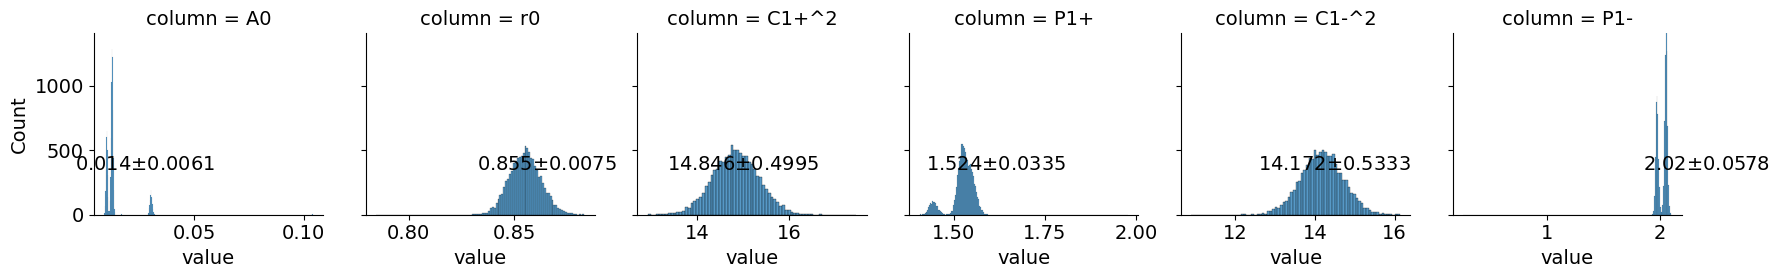

In [287]:
samples_melted = samples.melt(var_name='column')
plt.rcParams.update({'font.size': 14})
g = sns.FacetGrid(samples_melted, col='column', sharex=False)
g.map(specs, 'value', top  = 350)
plt.show()

# Full covariance fit and analysis

In [122]:
seeds = [i + 35 for i in range(15)]
for seed in seeds:
    torch.manual_seed(seed)

    ### Data 
    x_train = torch.tensor(data_train.theta_cs)
    y_train = torch.tensor(data_train.cs_data)

    ### torch.nn.Module class instance
    nMC = 5
    param_dim = 6
    x_dim = 1

    model = MCElboFG(nMC = nMC, x_dim = x_dim,
                     param_dim = param_dim,
                     f_dim = data_train.f_bounds.shape[0],
                     theta_cs = data_train.theta_cs,
                     err_cs = data_train.err_cs,
                     Elab_cs = data_train.Elab_cs, f_sigmas = data_train.f_sigmas, cov_theory = True, recompute_values = True,
                     which_data = "som", barnard_Elab = None, l_som = data_train.l_som)

    learning_rate = 5e-3
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    n_steps = 30000
    # Saving intermediate results
    loss_array = np.zeros(n_steps)
    time_array = np.zeros(n_steps)
    param_dictionary = {}
    for name, param in model.named_parameters():
        param_dictionary[name] = []

    startTime = time.time()
    for t in range(n_steps):
        # Compute ELBO
        loss = - model.compute_elbo_loop(x_train, y_train)
        # Zero gradinets
        optimizer.zero_grad()
        # Compute gradients
        loss.backward()
        optimizer.step()

        # Utiliti computation
        loss_array[t] = loss.item()
        time_array[t] = time.time() - startTime 

        if t % 10 == 9: 
            for name, param in model.named_parameters():
                param_dictionary[name] = param_dictionary[name] + [param.detach().clone().numpy()]

        if t % 2000 == 1999:
            print(f"Loss: {loss.item()}, Step [{t}/{n_steps}]")
            print(model.ModelString())
            # Time estimmate
            print(f"Minutes remaining {(time.time() - startTime) * (n_steps - t) / (t * 60)}")

    endTime = time.time()
    print(endTime - startTime)

    folder = "Outputs"
    run_id = "som_full_" + str(seed) + "_"

    if not os.path.exists(folder):
        os.makedirs(folder)

    dictionary_outputs = copy.deepcopy(param_dictionary)
    dictionary_outputs["ELBO"] = -loss_array
    dictionary_outputs["time"] = time_array
    with open(folder + "/" + run_id + "outputs_" + "vars" + '.pickle', 'wb') as handle:
        pkl.dump(dictionary_outputs, handle, protocol=pkl.HIGHEST_PROTOCOL)

Loss: 19332.55078125, Step [1999/30000]
theta mean: Parameter containing:
tensor([[ 0.1280,  0.7377, 13.7274, -0.1327, 12.5210, -0.0754,  0.9424,  0.8916,
          1.0431,  1.0070,  1.0484,  1.0531,  1.0603]], dtype=torch.float64,
       requires_grad=True) 
 theta std tensor([[0.0147, 0.3450, 1.6708, 1.5440, 1.7642, 1.5563, 0.0211, 0.0231, 0.0343,
         0.0248, 0.0207, 0.0210, 0.0149]], dtype=torch.float64,
       grad_fn=<SoftplusBackward0>)
Minutes remaining 14.343289721020067
Loss: 1888.2142333984375, Step [3999/30000]
theta mean: Parameter containing:
tensor([[ 0.0980,  0.6778, 13.4029, -0.4586, 12.3907, -0.2756,  0.9603,  0.9158,
          1.0739,  1.0387,  1.0828,  1.1017,  1.1095]], dtype=torch.float64,
       requires_grad=True) 
 theta std tensor([[0.0152, 0.3075, 1.6929, 1.2260, 1.6839, 1.3790, 0.0107, 0.0111, 0.0167,
         0.0124, 0.0116, 0.0113, 0.0079]], dtype=torch.float64,
       grad_fn=<SoftplusBackward0>)
Minutes remaining 14.061122975784052
Loss: 879.80743408

Loss: 998.9788208007812, Step [3999/30000]
theta mean: Parameter containing:
tensor([[ 0.1324,  0.6480, 13.4311, -0.3862, 12.1602, -0.4436,  0.9421,  0.8938,
          1.0569,  1.0291,  1.0790,  1.0939,  1.1007]], dtype=torch.float64,
       requires_grad=True) 
 theta std tensor([[0.0179, 0.3287, 1.6596, 1.2468, 1.8767, 1.2615, 0.0126, 0.0107, 0.0123,
         0.0119, 0.0113, 0.0134, 0.0112]], dtype=torch.float64,
       grad_fn=<SoftplusBackward0>)
Minutes remaining 12.049677387083372
Loss: 709.5266723632812, Step [5999/30000]
theta mean: Parameter containing:
tensor([[ 0.0675,  0.5921, 13.3174, -0.5057, 11.9544, -0.6850,  0.9636,  0.9188,
          1.0880,  1.0737,  1.1394,  1.1702,  1.1813]], dtype=torch.float64,
       requires_grad=True) 
 theta std tensor([[0.0222, 0.2640, 1.6154, 1.0728, 1.8120, 0.9837, 0.0079, 0.0064, 0.0073,
         0.0070, 0.0068, 0.0084, 0.0071]], dtype=torch.float64,
       grad_fn=<SoftplusBackward0>)
Minutes remaining 11.037396134233028
Loss: 749.796875

Loss: 813.428955078125, Step [7999/30000]
theta mean: Parameter containing:
tensor([[ 4.9529e-02,  5.5720e-03,  1.3201e+01, -7.1456e-01,  1.2088e+01,
         -5.8300e-01,  9.5554e-01,  9.1292e-01,  1.0797e+00,  1.0692e+00,
          1.1387e+00,  1.1823e+00,  1.1921e+00]], dtype=torch.float64,
       requires_grad=True) 
 theta std tensor([[0.0129, 0.1176, 1.0800, 0.7861, 1.3641, 0.8634, 0.0056, 0.0045, 0.0044,
         0.0042, 0.0043, 0.0042, 0.0037]], dtype=torch.float64,
       grad_fn=<SoftplusBackward0>)
Minutes remaining 10.002255678842548
Loss: 324.76495361328125, Step [9999/30000]
theta mean: Parameter containing:
tensor([[ 1.0602e-03,  9.5513e-02,  1.3751e+01, -2.8462e-01,  1.2564e+01,
         -1.8148e-01,  9.8309e-01,  9.3769e-01,  1.1015e+00,  1.1039e+00,
          1.1812e+00,  1.2489e+00,  1.2600e+00]], dtype=torch.float64,
       requires_grad=True) 
 theta std tensor([[0.0113, 0.0946, 0.9915, 0.6665, 1.3130, 0.7401, 0.0053, 0.0038, 0.0033,
         0.0033, 0.0030, 0.0032

Loss: 3359.776123046875, Step [9999/30000]
theta mean: Parameter containing:
tensor([[-1.6388e-03,  7.9358e-05,  1.3564e+01, -4.4879e-01,  1.2487e+01,
         -2.8287e-01,  9.6787e-01,  9.2065e-01,  1.0890e+00,  1.1072e+00,
          1.1844e+00,  1.2604e+00,  1.2667e+00]], dtype=torch.float64,
       requires_grad=True) 
 theta std tensor([[0.0143, 0.1310, 1.0659, 0.7861, 1.4917, 0.7733, 0.0052, 0.0038, 0.0036,
         0.0035, 0.0030, 0.0034, 0.0029]], dtype=torch.float64,
       grad_fn=<SoftplusBackward0>)
Minutes remaining 9.929960849799208
Loss: 188.30508422851562, Step [11999/30000]
theta mean: Parameter containing:
tensor([[9.1769e-03, 2.6887e-01, 1.4360e+01, 2.8546e-01, 1.3386e+01, 5.7498e-01,
         9.7405e-01, 9.2944e-01, 1.0893e+00, 1.0792e+00, 1.1355e+00, 1.1732e+00,
         1.1785e+00]], dtype=torch.float64, requires_grad=True) 
 theta std tensor([[0.0120, 0.1128, 1.0286, 0.5709, 1.3427, 0.6215, 0.0053, 0.0039, 0.0031,
         0.0037, 0.0027, 0.0030, 0.0030]], dtype=t

Loss: 16.498722076416016, Step [11999/30000]
theta mean: Parameter containing:
tensor([[-4.0115e-04,  2.1124e-01,  1.4443e+01,  6.1792e-01,  1.3270e+01,
          5.1833e-01,  9.6851e-01,  9.2610e-01,  1.0753e+00,  1.0681e+00,
          1.1292e+00,  1.1756e+00,  1.1864e+00]], dtype=torch.float64,
       requires_grad=True) 
 theta std tensor([[0.0083, 0.0760, 1.4190, 0.5569, 1.2473, 0.5903, 0.0052, 0.0037, 0.0030,
         0.0030, 0.0026, 0.0030, 0.0028]], dtype=torch.float64,
       grad_fn=<SoftplusBackward0>)
Minutes remaining 8.512283519288514
Loss: -434.7822265625, Step [13999/30000]
theta mean: Parameter containing:
tensor([[9.8782e-03, 7.0740e-01, 1.5094e+01, 1.3591e+00, 1.4232e+01, 1.6412e+00,
         9.7911e-01, 9.3294e-01, 1.0701e+00, 1.0342e+00, 1.0665e+00, 1.0727e+00,
         1.0816e+00]], dtype=torch.float64, requires_grad=True) 
 theta std tensor([[0.0058, 0.0450, 1.3246, 0.2751, 1.2422, 0.2705, 0.0053, 0.0036, 0.0032,
         0.0031, 0.0025, 0.0031, 0.0022]], dtype=to

Loss: -9.24019718170166, Step [13999/30000]
theta mean: Parameter containing:
tensor([[ 0.0899,  0.7343, 15.1150,  1.1847, 14.3255,  1.5196,  0.9307,  0.8791,
          1.0170,  0.9638,  0.9842,  0.9531,  0.9625]], dtype=torch.float64,
       requires_grad=True) 
 theta std tensor([[0.0163, 0.0912, 1.0126, 0.3161, 1.1637, 0.3530, 0.0053, 0.0038, 0.0030,
         0.0030, 0.0028, 0.0030, 0.0024]], dtype=torch.float64,
       grad_fn=<SoftplusBackward0>)
Minutes remaining 8.039245043102468
Loss: -278.9684143066406, Step [15999/30000]
theta mean: Parameter containing:
tensor([[ 0.0385,  0.9347, 15.0440,  1.4658, 14.3201,  1.8695,  0.9559,  0.9074,
          1.0419,  0.9898,  0.9984,  0.9733,  0.9837]], dtype=torch.float64,
       requires_grad=True) 
 theta std tensor([[0.0132, 0.0502, 1.1428, 0.1457, 1.2512, 0.1474, 0.0052, 0.0037, 0.0031,
         0.0028, 0.0026, 0.0026, 0.0021]], dtype=torch.float64,
       grad_fn=<SoftplusBackward0>)
Minutes remaining 6.934711549816165
Loss: -341.9801

Loss: -332.8362121582031, Step [17999/30000]
theta mean: Parameter containing:
tensor([[ 0.0175,  0.8919, 14.8447,  1.6003, 14.0267,  1.8607,  0.9753,  0.9269,
          1.0636,  1.0066,  1.0188,  1.0177,  1.0356]], dtype=torch.float64,
       requires_grad=True) 
 theta std tensor([[0.0079, 0.0206, 1.2975, 0.0865, 1.4069, 0.0963, 0.0053, 0.0040, 0.0030,
         0.0029, 0.0023, 0.0024, 0.0021]], dtype=torch.float64,
       grad_fn=<SoftplusBackward0>)
Minutes remaining 5.530417328366378
Loss: -476.0752868652344, Step [19999/30000]
theta mean: Parameter containing:
tensor([[1.3040e-02, 8.8099e-01, 1.4773e+01, 1.6344e+00, 1.3832e+01, 1.8574e+00,
         9.8298e-01, 9.3370e-01, 1.0621e+00, 1.0172e+00, 1.0308e+00, 1.0326e+00,
         1.0397e+00]], dtype=torch.float64, requires_grad=True) 
 theta std tensor([[0.0056, 0.0173, 1.2931, 0.0596, 1.4140, 0.0722, 0.0051, 0.0038, 0.0030,
         0.0027, 0.0023, 0.0025, 0.0021]], dtype=torch.float64,
       grad_fn=<SoftplusBackward0>)
Minutes r

Loss: -498.1936950683594, Step [19999/30000]
theta mean: Parameter containing:
tensor([[1.2590e-02, 8.6596e-01, 1.4989e+01, 1.6576e+00, 1.3841e+01, 1.8274e+00,
         9.8430e-01, 9.3672e-01, 1.0703e+00, 1.0209e+00, 1.0430e+00, 1.0388e+00,
         1.0417e+00]], dtype=torch.float64, requires_grad=True) 
 theta std tensor([[0.0020, 0.0169, 1.2855, 0.0565, 1.4147, 0.0708, 0.0052, 0.0037, 0.0028,
         0.0030, 0.0024, 0.0025, 0.0022]], dtype=torch.float64,
       grad_fn=<SoftplusBackward0>)
Minutes remaining 4.608968539397288
Loss: -487.30596923828125, Step [21999/30000]
theta mean: Parameter containing:
tensor([[1.2983e-02, 8.6550e-01, 1.4900e+01, 1.6368e+00, 1.3830e+01, 1.8635e+00,
         9.8037e-01, 9.2752e-01, 1.0689e+00, 1.0183e+00, 1.0352e+00, 1.0350e+00,
         1.0441e+00]], dtype=torch.float64, requires_grad=True) 
 theta std tensor([[0.0017, 0.0171, 1.3029, 0.0461, 1.4374, 0.0517, 0.0054, 0.0037, 0.0029,
         0.0027, 0.0023, 0.0025, 0.0021]], dtype=torch.float64,
   

Loss: -468.3392639160156, Step [23999/30000]
theta mean: Parameter containing:
tensor([[1.2929e-02, 8.6780e-01, 1.4801e+01, 1.6199e+00, 1.3782e+01, 1.8898e+00,
         9.7912e-01, 9.2898e-01, 1.0665e+00, 1.0183e+00, 1.0337e+00, 1.0307e+00,
         1.0425e+00]], dtype=torch.float64, requires_grad=True) 
 theta std tensor([[0.0027, 0.0165, 1.2775, 0.0472, 1.3984, 0.0433, 0.0056, 0.0038, 0.0029,
         0.0029, 0.0026, 0.0026, 0.0021]], dtype=torch.float64,
       grad_fn=<SoftplusBackward0>)
Minutes remaining 2.863567949983546
Loss: -506.2470703125, Step [25999/30000]
theta mean: Parameter containing:
tensor([[1.1546e-02, 8.6949e-01, 1.4804e+01, 1.6243e+00, 1.3793e+01, 1.8951e+00,
         9.7709e-01, 9.3492e-01, 1.0618e+00, 1.0229e+00, 1.0364e+00, 1.0366e+00,
         1.0407e+00]], dtype=torch.float64, requires_grad=True) 
 theta std tensor([[0.0020, 0.0173, 1.3169, 0.0419, 1.3862, 0.0424, 0.0053, 0.0038, 0.0032,
         0.0028, 0.0023, 0.0024, 0.0022]], dtype=torch.float64,
       

Loss: -402.6633605957031, Step [25999/30000]
theta mean: Parameter containing:
tensor([[1.2644e-02, 8.6063e-01, 1.5245e+01, 1.9167e+00, 1.3108e+01, 9.8478e-01,
         9.7789e-01, 9.3141e-01, 1.0660e+00, 1.0168e+00, 1.0386e+00, 1.0302e+00,
         1.0325e+00]], dtype=torch.float64, requires_grad=True) 
 theta std tensor([[0.0018, 0.0176, 1.1844, 0.0318, 1.7106, 0.0874, 0.0052, 0.0036, 0.0030,
         0.0028, 0.0023, 0.0025, 0.0022]], dtype=torch.float64,
       grad_fn=<SoftplusBackward0>)
Minutes remaining 1.839377558717838
Loss: -486.28271484375, Step [27999/30000]
theta mean: Parameter containing:
tensor([[1.2054e-02, 8.6098e-01, 1.5248e+01, 1.9208e+00, 1.3136e+01, 9.8928e-01,
         9.8152e-01, 9.3258e-01, 1.0654e+00, 1.0205e+00, 1.0343e+00, 1.0260e+00,
         1.0462e+00]], dtype=torch.float64, requires_grad=True) 
 theta std tensor([[0.0017, 0.0172, 1.1817, 0.0322, 1.6407, 0.0841, 0.0054, 0.0037, 0.0028,
         0.0029, 0.0023, 0.0026, 0.0024]], dtype=torch.float64,
      

Loss: -474.41888427734375, Step [27999/30000]
theta mean: Parameter containing:
tensor([[1.3525e-02, 8.6009e-01, 1.4816e+01, 1.6125e+00, 1.3819e+01, 1.8885e+00,
         9.7975e-01, 9.3154e-01, 1.0641e+00, 1.0179e+00, 1.0316e+00, 1.0278e+00,
         1.0382e+00]], dtype=torch.float64, requires_grad=True) 
 theta std tensor([[0.0016, 0.0173, 1.3282, 0.0414, 1.4303, 0.0432, 0.0053, 0.0038, 0.0028,
         0.0031, 0.0019, 0.0028, 0.0023]], dtype=torch.float64,
       grad_fn=<SoftplusBackward0>)
Minutes remaining 0.9199703673996403
Loss: -455.11199951171875, Step [29999/30000]
theta mean: Parameter containing:
tensor([[1.2023e-02, 8.6667e-01, 1.4827e+01, 1.6209e+00, 1.3826e+01, 1.8881e+00,
         9.7825e-01, 9.3284e-01, 1.0658e+00, 1.0182e+00, 1.0312e+00, 1.0432e+00,
         1.0360e+00]], dtype=torch.float64, requires_grad=True) 
 theta std tensor([[0.0016, 0.0170, 1.2962, 0.0418, 1.3855, 0.0443, 0.0054, 0.0036, 0.0030,
         0.0029, 0.0024, 0.0024, 0.0020]], dtype=torch.float64,
 

Loss: -420.48504638671875, Step [29999/30000]
theta mean: Parameter containing:
tensor([[1.2593e-02, 8.5861e-01, 1.4810e+01, 1.6181e+00, 1.3819e+01, 1.8948e+00,
         9.7924e-01, 9.3106e-01, 1.0729e+00, 1.0159e+00, 1.0379e+00, 1.0266e+00,
         1.0383e+00]], dtype=torch.float64, requires_grad=True) 
 theta std tensor([[0.0016, 0.0170, 1.3164, 0.0417, 1.4306, 0.0446, 0.0054, 0.0037, 0.0028,
         0.0029, 0.0024, 0.0027, 0.0022]], dtype=torch.float64,
       grad_fn=<SoftplusBackward0>)
Minutes remaining 0.00046157224303594103
830.8023431301117
Loss: 973.9381103515625, Step [1999/30000]
theta mean: Parameter containing:
tensor([[ 0.1227,  0.7054, 13.6583, -0.2253, 12.4792, -0.1429,  0.9411,  0.8968,
          1.0459,  1.0047,  1.0373,  1.0539,  1.0646]], dtype=torch.float64,
       requires_grad=True) 
 theta std tensor([[0.0150, 0.3757, 1.5072, 1.4543, 1.7934, 1.5210, 0.0240, 0.0174, 0.0313,
         0.0226, 0.0149, 0.0213, 0.0179]], dtype=torch.float64,
       grad_fn=<Softplu

Loss: 1260.302490234375, Step [1999/30000]
theta mean: Parameter containing:
tensor([[ 0.1234,  0.6772, 13.6483, -0.1694, 12.3399, -0.2297,  0.9423,  0.8959,
          1.0520,  1.0183,  1.0609,  1.0673,  1.0762]], dtype=torch.float64,
       requires_grad=True) 
 theta std tensor([[0.0167, 0.3395, 1.7058, 1.5079, 1.8464, 1.4807, 0.0199, 0.0245, 0.0285,
         0.0247, 0.0255, 0.0235, 0.0214]], dtype=torch.float64,
       grad_fn=<SoftplusBackward0>)
Minutes remaining 13.174768862134718
Loss: 864.1082763671875, Step [3999/30000]
theta mean: Parameter containing:
tensor([[ 0.1076,  0.6543, 13.3118, -0.4540, 12.0836, -0.5161,  0.9501,  0.9036,
          1.0694,  1.0470,  1.0999,  1.1160,  1.1274]], dtype=torch.float64,
       requires_grad=True) 
 theta std tensor([[0.0174, 0.3172, 1.7137, 1.2035, 1.7507, 1.2124, 0.0103, 0.0124, 0.0134,
         0.0127, 0.0127, 0.0119, 0.0113]], dtype=torch.float64,
       grad_fn=<SoftplusBackward0>)
Minutes remaining 13.034846375923987
Loss: 705.950805

Loss: 747.6373901367188, Step [5999/30000]
theta mean: Parameter containing:
tensor([[ 0.0521,  0.5072, 13.1468, -0.6660, 11.8629, -0.7259,  0.9663,  0.9234,
          1.0949,  1.0844,  1.1530,  1.1988,  1.2091]], dtype=torch.float64,
       requires_grad=True) 
 theta std tensor([[0.0171, 0.2628, 1.2945, 1.0327, 1.6104, 0.8858, 0.0075, 0.0068, 0.0088,
         0.0065, 0.0074, 0.0089, 0.0065]], dtype=torch.float64,
       grad_fn=<SoftplusBackward0>)
Minutes remaining 11.174899904653218
Loss: 842.3118286132812, Step [7999/30000]
theta mean: Parameter containing:
tensor([[ 0.0802, -0.1042, 13.1919, -0.6893, 12.0315, -0.6149,  0.9473,  0.8993,
          1.0623,  1.0513,  1.1224,  1.1579,  1.1675]], dtype=torch.float64,
       requires_grad=True) 
 theta std tensor([[0.0152, 0.1523, 1.1571, 0.8843, 1.5183, 0.8263, 0.0059, 0.0046, 0.0054,
         0.0044, 0.0046, 0.0057, 0.0041]], dtype=torch.float64,
       grad_fn=<SoftplusBackward0>)
Minutes remaining 10.18650299940486
Loss: 518.1794433

## Loading results

In [37]:
folder = "Outputs"
run_id = "som_full_3_"

with open(folder + "/" + run_id + "outputs_" + "vars" + '.pickle', 'rb') as handle:
    dictionary_outputs = pkl.load(handle)
time_array = dictionary_outputs["time"]
loss_array = - dictionary_outputs["ELBO"]
param_dictionary = copy.deepcopy(dictionary_outputs)

## Fit plots

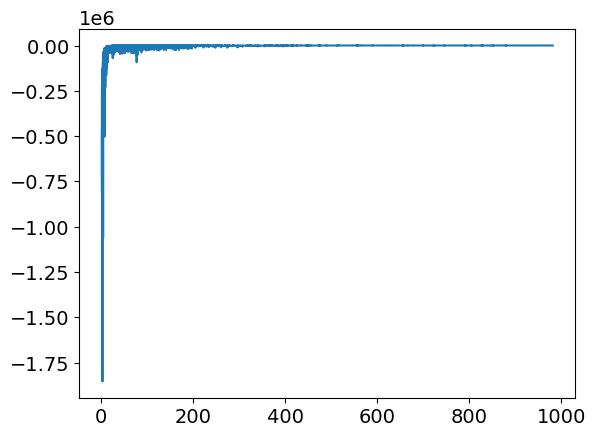

In [38]:
# ELBO
plt.plot(time_array[50:], -loss_array[50:])
plt.show()

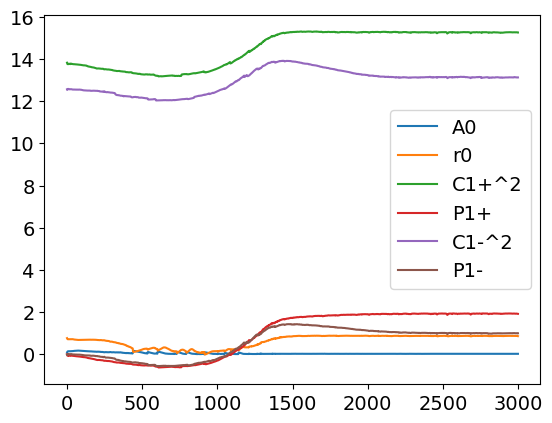

In [39]:
# means
plt.plot(np.array(param_dictionary["q_theta_m"])[:,0,:6])
plt.legend(names)
plt.show()

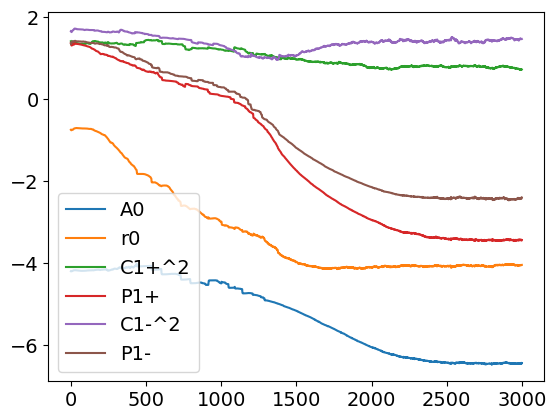

In [40]:
# SD
plt.plot(np.array(param_dictionary["q_theta_s"])[:,0,:6])
plt.legend(names)
plt.show()

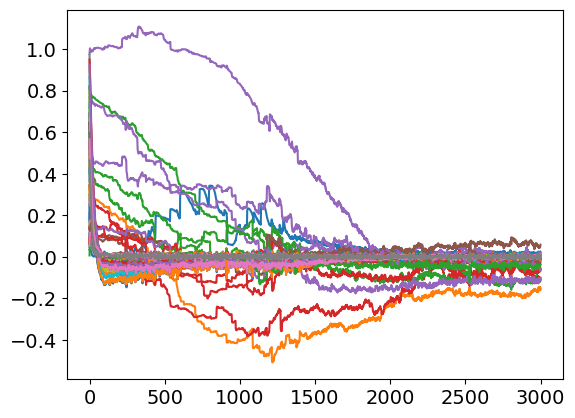

In [41]:
# Cholesky factor components for covariance matrix
plt.plot(np.array(param_dictionary["q_theta_c"])[:,0,:])
plt.show()

### Posteriors - Multiple runs

In [123]:
folder = "Outputs"

ELBO = {}
posteriors = {}

for seed in range(50):
    run_id = "som_full_" + str(seed) + "_"
    with open(folder + "/" + run_id + "outputs_" + "vars" + '.pickle', 'rb') as handle:
        dictionary_outputs = pkl.load(handle)
    time_array = dictionary_outputs["time"]
    loss_array = - dictionary_outputs["ELBO"]
    ELBO[run_id] = loss_array
    param_dictionary = copy.deepcopy(dictionary_outputs)
    posteriors[run_id] = param_dictionary

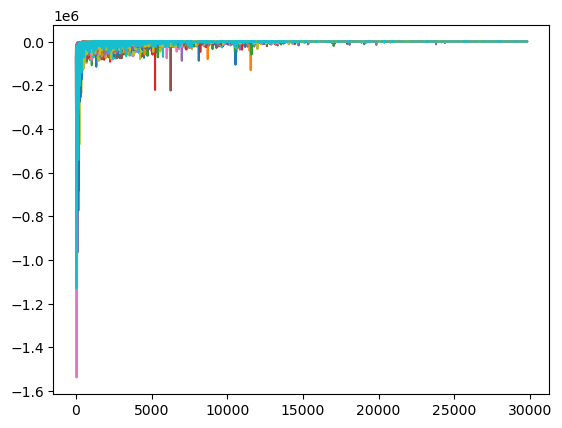

In [124]:
weights = {}
for index, (key, value) in enumerate(ELBO.items()):
    plt.plot(- value[200:])
    weights[key] = np.mean(- value[-10000:])
plt.show()
weights = pd.DataFrame(weights.items())
weights.columns = ["id", "ELBO"]
weights["p"] = np.exp(weights["ELBO"]) / np.sum(np.exp(weights["ELBO"]))
weights["pCum"] = np.cumsum(weights["p"])

<AxesSubplot:>

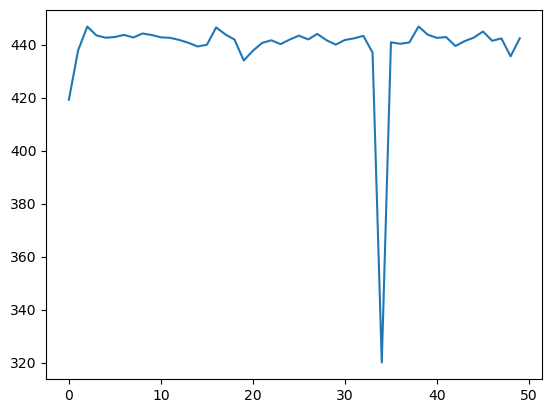

In [126]:
weights["ELBO"].plot()

<AxesSubplot:>

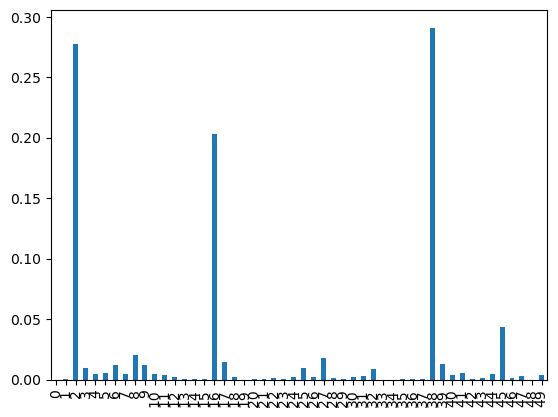

In [127]:
weights["p"].plot.bar()

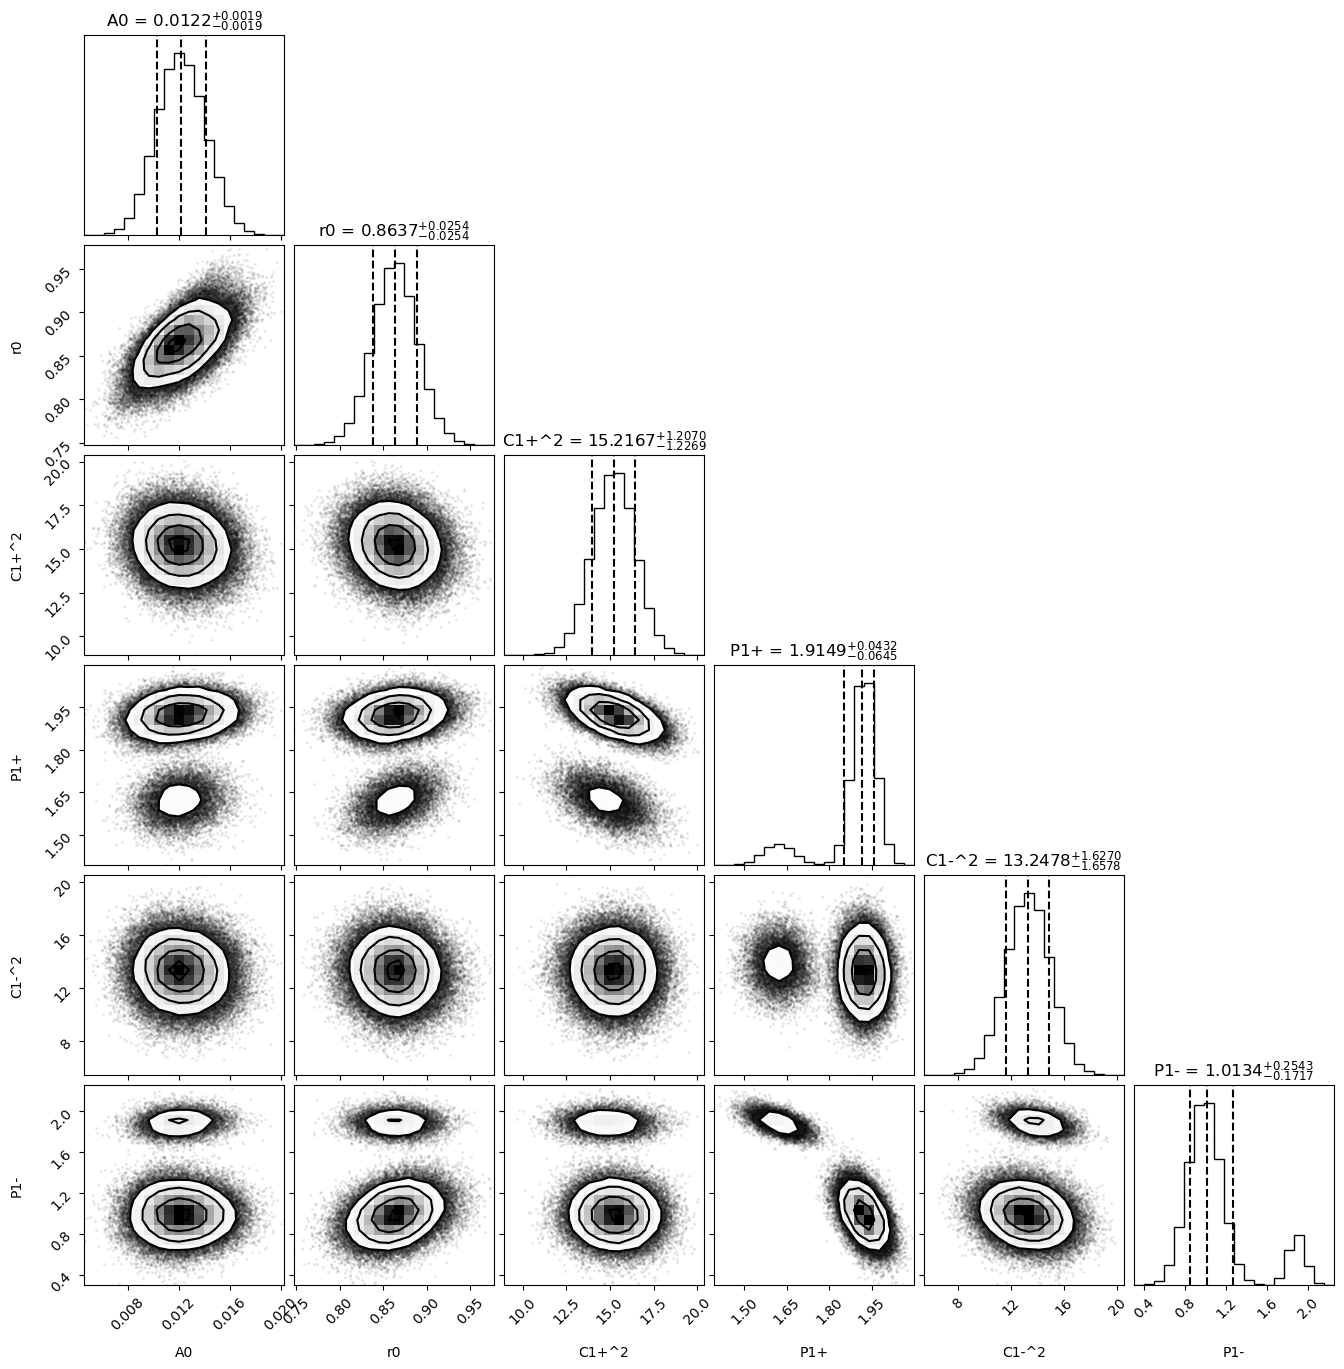

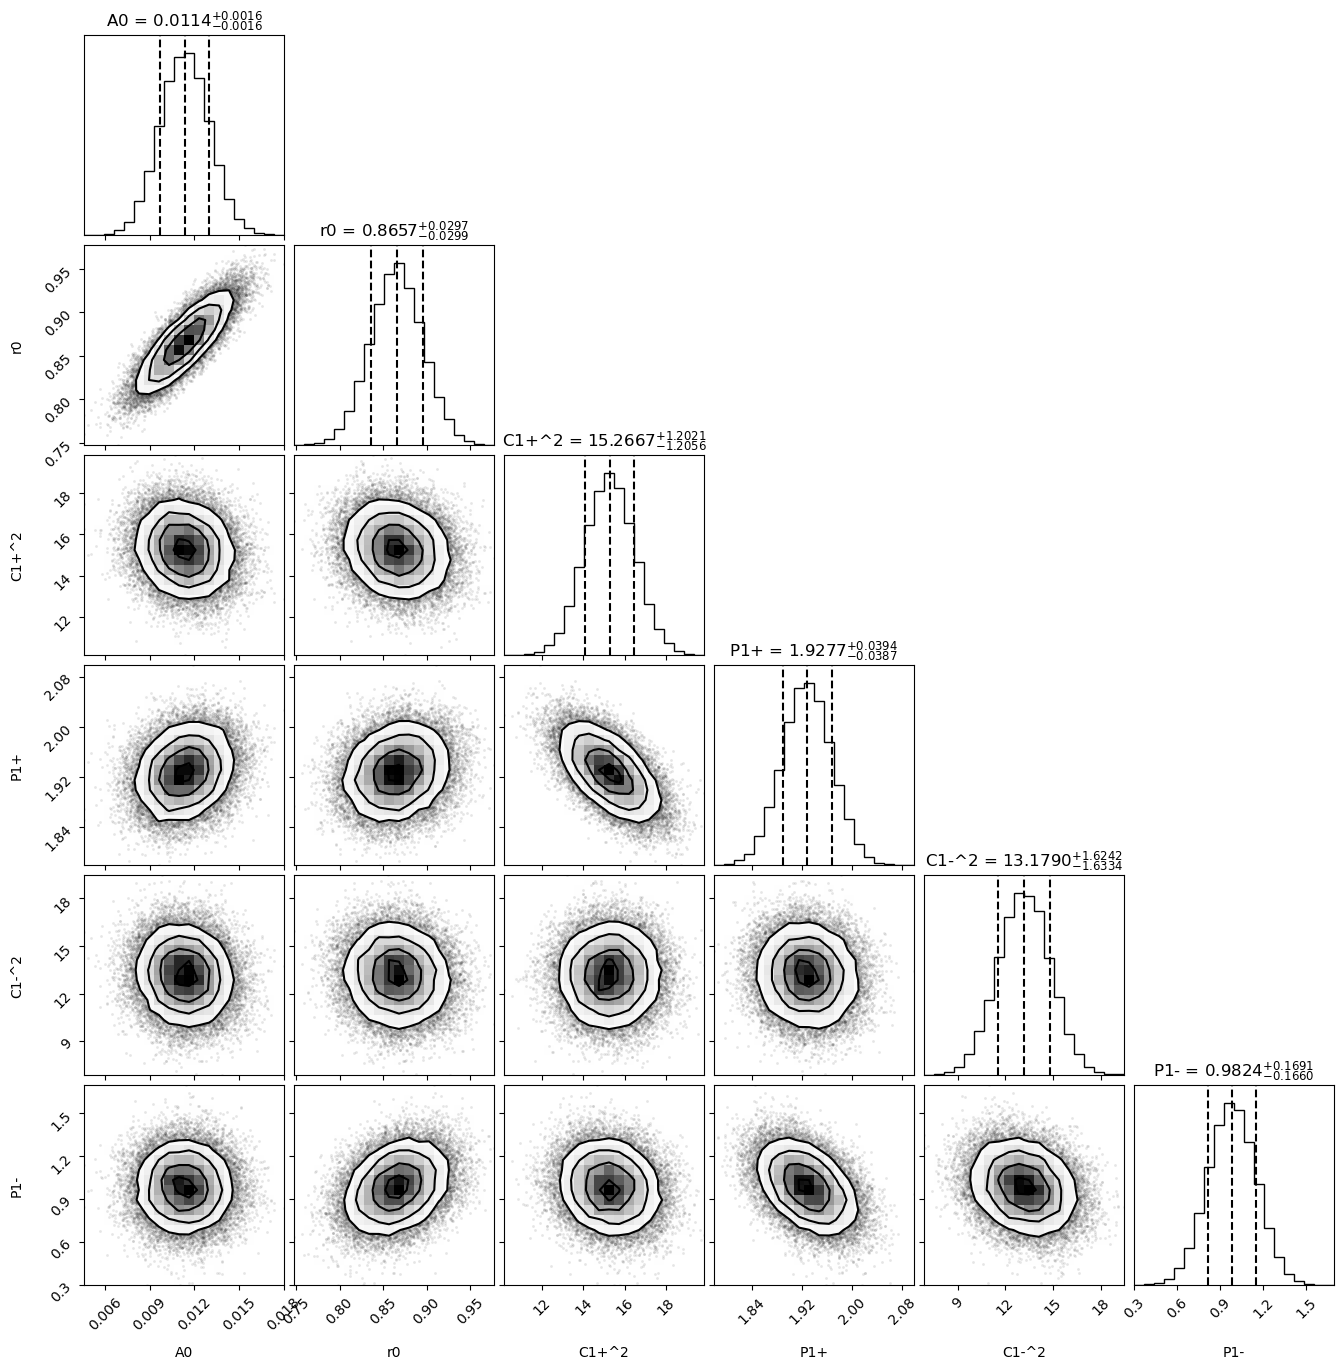

In [130]:
# VI Psoteriors
samples = 100000
theta = np.zeros((samples, model.param_dim + model.f_dim))
indices_array = np.zeros(samples)
for i in range(samples):
    u = np.random.uniform()
    states = (weights["pCum"] - u) > 0
    #index_model = str(i % 25)
    #indices_array[i] = i % 25
    index_model = str(np.where(states)[0][0])
    indices_array[i] = np.where(states)[0][0]
    #index_model = str(2)
    #print(index)
    model.nMC = 1
    z = model.generate_sample(n_var = model.param_dim + model.f_dim)
    U = torch.zeros((model.param_dim + model.f_dim ,model.param_dim + model.f_dim), dtype=torch.float64)
    U[model.up_i] = torch.tensor(posteriors['som_full_'+ index_model + '_']['q_theta_c'][-1])
    U[model.diag_i] = model.softplus(torch.tensor(posteriors['som_full_'+ index_model + '_']['q_theta_s'][-1]))
    L = U.T
    theta[i,:]  = model.sample_reparam_normal(z[0,:,:], torch.tensor(posteriors['som_full_'+ index_model + '_']['q_theta_m'][-1]), L).numpy().flatten() 

samples = pd.DataFrame(theta[:,:6], columns = names)
corner.corner(samples.values, labels = samples.columns, quantiles = [0.16, 0.5, 0.84], title_fmt = '.4f', show_titles = True)
plt.show()
# Top model
samples = pd.DataFrame(theta[indices_array == 2,:6], columns = names)
corner.corner(samples.values, labels = samples.columns, quantiles = [0.16, 0.5, 0.84], title_fmt = '.4f', show_titles = True)
plt.show()

### Correlations

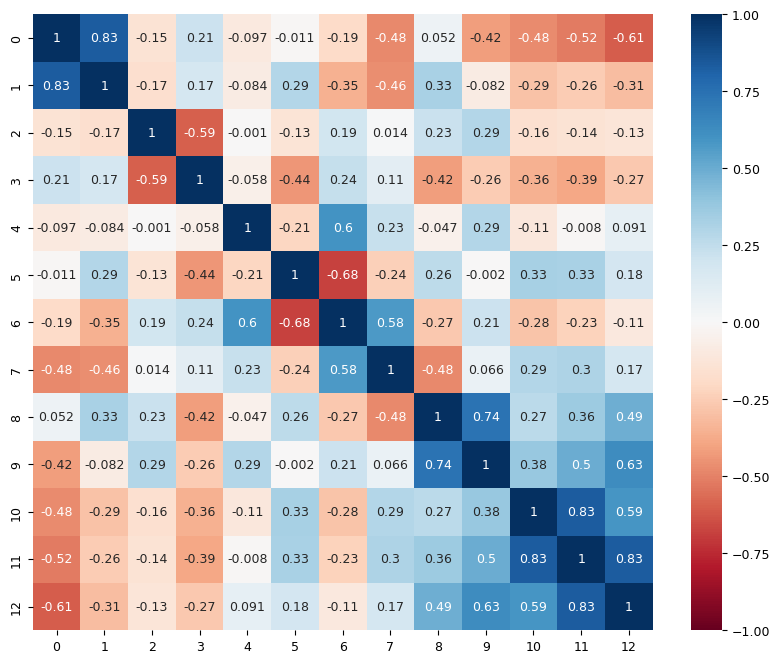

In [27]:
# All parameters
L = model.cholesky_factor()
S = L @ L.T
plt.figure(figsize=(10, 8))
plt.rcParams.update({'font.size': 9})
cmap = "RdBu"
sns.heatmap(np.around(correlation_from_covariance(S.detach().numpy()), decimals = 3), vmin=-1, vmax=1, annot=True, cmap = cmap)
plt.show()

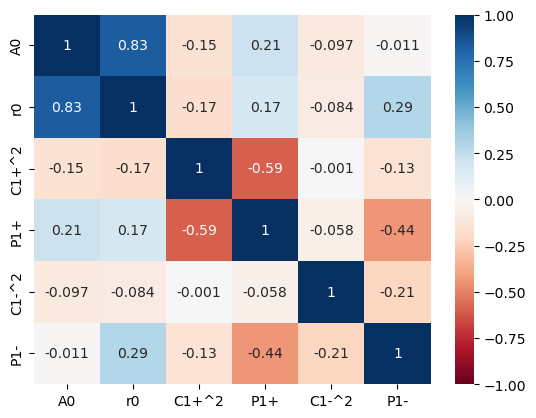

In [28]:
# Calibration parameters only
plt.rcParams.update({'font.size': 10})
cmap = "RdBu"
sns.heatmap(pd.DataFrame(np.around(correlation_from_covariance(S.detach().numpy()), decimals = 3)[:6,:6], columns = names, index = names), vmin=-1, vmax=1, annot=True, cmap=cmap)
plt.show()

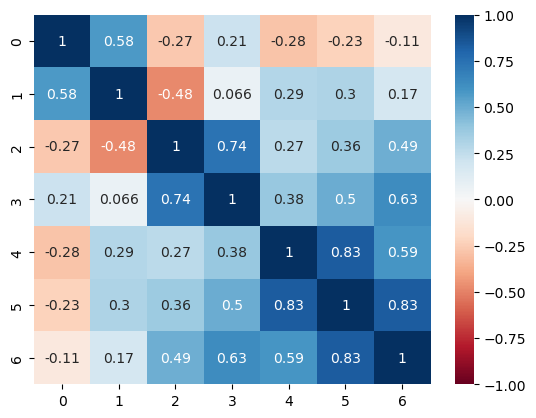

In [29]:
# Normalizing factors only
plt.rcParams.update({'font.size': 10})
cmap = "RdBu"
sns.heatmap(np.around(correlation_from_covariance(S.detach().numpy()), decimals = 3)[6:,6:], vmin=-1, vmax=1, annot=True, cmap = cmap)
plt.show()

### Posteriors

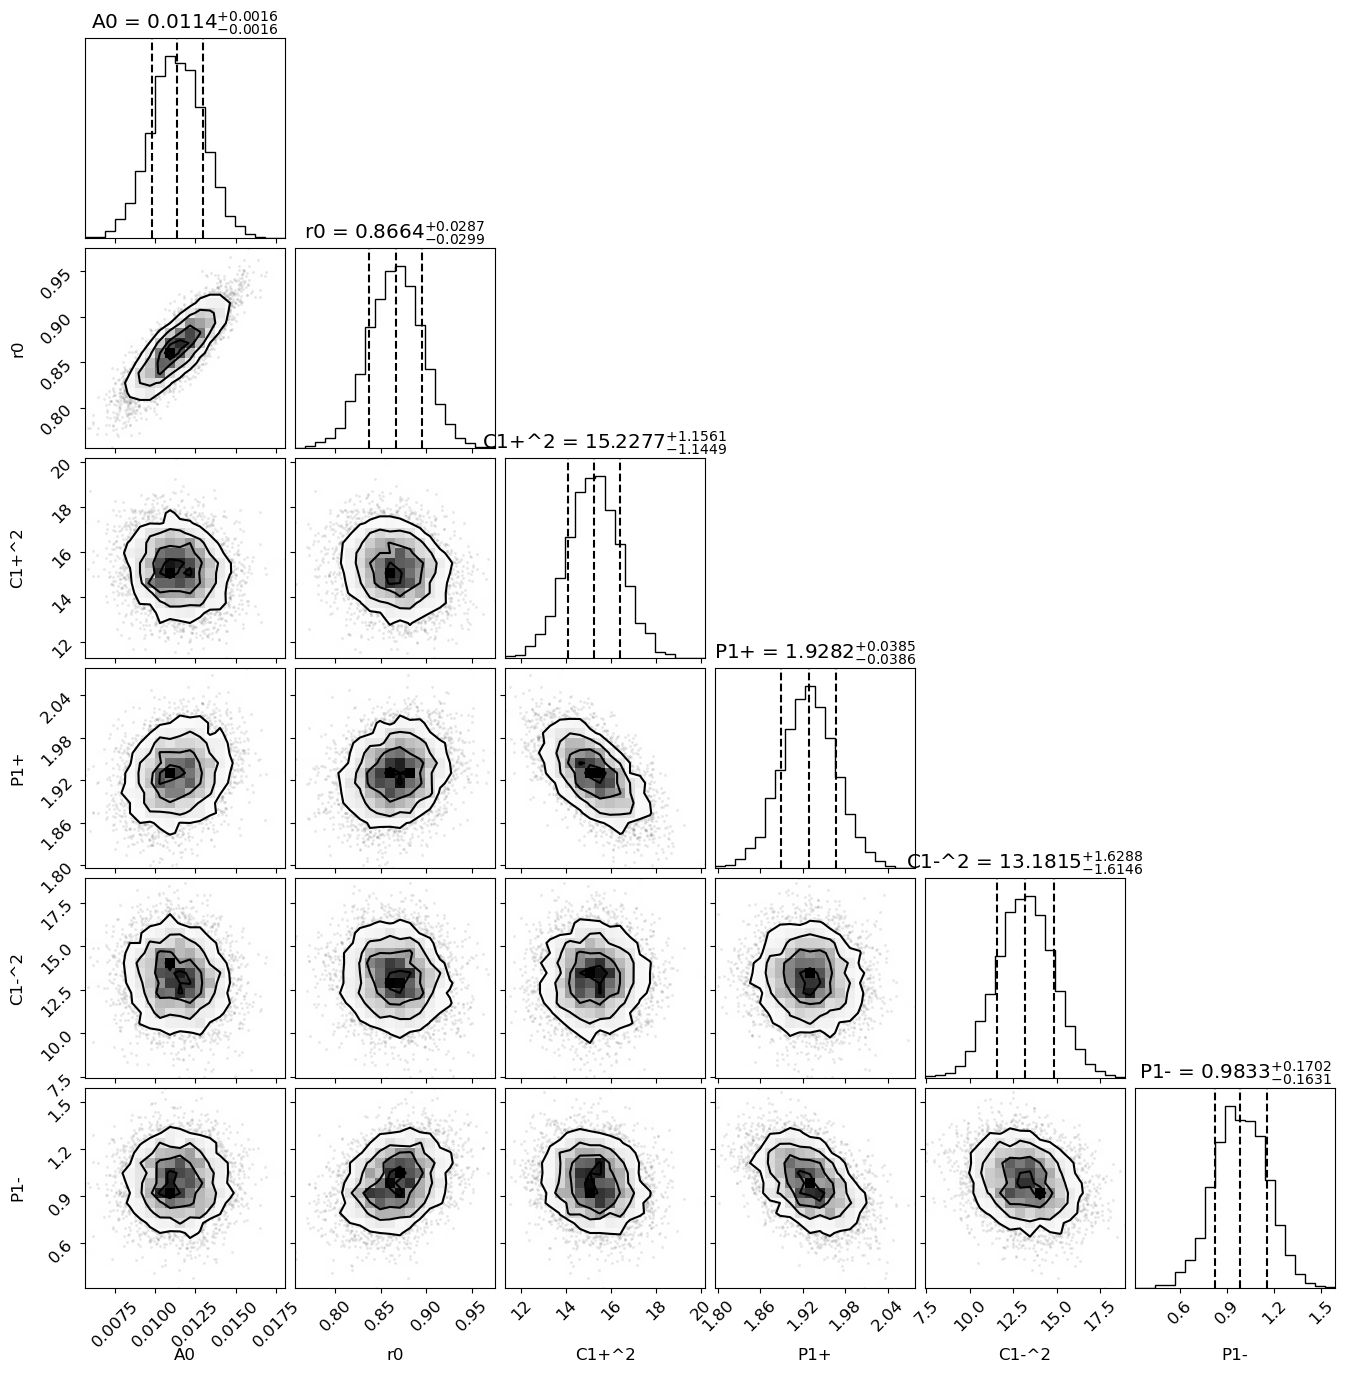

In [30]:
# VI Psoteriors
model.nMC = 5000
L = model.cholesky_factor()
z = model.generate_sample(n_var = model.param_dim + model.f_dim)
theta = model.sample_reparam_normal(z, model.q_theta_m, L)   

alpha = 1
bins = 100
plt.rcParams.update({'font.size': 12})
samples = pd.DataFrame(theta.detach().numpy().reshape(model.nMC, model.param_dim +model.f_dim)[:,:6], columns = names)
#g = sns.PairGrid(samples)
#g.map_diag(plt.hist, bins = bins, alpha = alpha, color = "blue", density= True)
#g.map_lower(sns.kdeplot, shade= True, thresh=0.05, color = "blue")
#plt.show()

corner.corner(samples.values, labels = samples.columns, quantiles = [0.16, 0.5, 0.84], title_fmt = '.4f', show_titles = True)
plt.show()

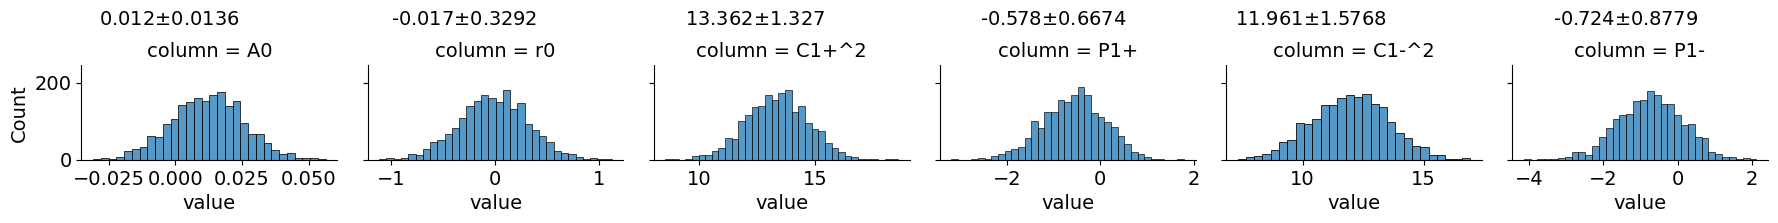

In [50]:
samples_melted = samples.melt(var_name='column')
plt.rcParams.update({'font.size': 14})
g = sns.FacetGrid(samples_melted, col='column', sharex=False)
g.map(specs, 'value', top  = 350)
plt.show()

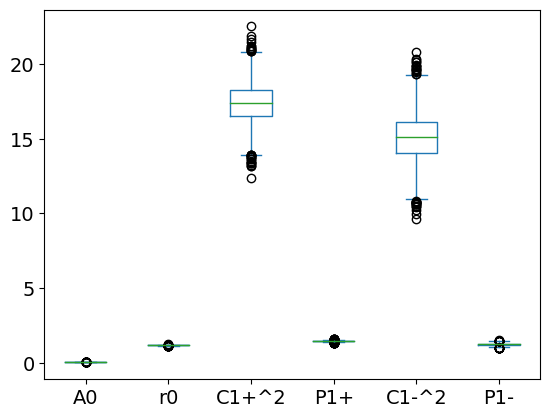

In [42]:
samples.plot(kind = "box")
plt.show()